# Data preparation

##Header files

In [ ]:
###Total header files required for the Model
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import rotate, shift
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import shuffle


##Import and Verify

In [ ]:
###Importing the dataset
file_path = 'dungeons_dataset.npy'
dataset = np.load(file_path)

###Verifying there's no missing records
missing_records = np.isnan(dataset).sum()

if missing_records == 0:
    print("There are no missing records in the dataset.")
else:
    print(f"There are {missing_records} missing records in the dataset.")

There are no missing records in the dataset.


##Normalizing and Formatting

In [ ]:
###Normalising the dataset
dataset_min = dataset.min()
dataset_max = dataset.max()
dataset_normalized = 2 * ((dataset - dataset_min) / (dataset_max - dataset_min)) - 1

###Adding the channel dimension - reshaping the dataset
dataset_reshaped = dataset_normalized.reshape((dataset_normalized.shape[0], 8, 8, 1))

print(f"Reshaped dataset shape: {dataset_reshaped.shape}")

Reshaped dataset shape: (253, 8, 8, 1)


##Visualising a subset

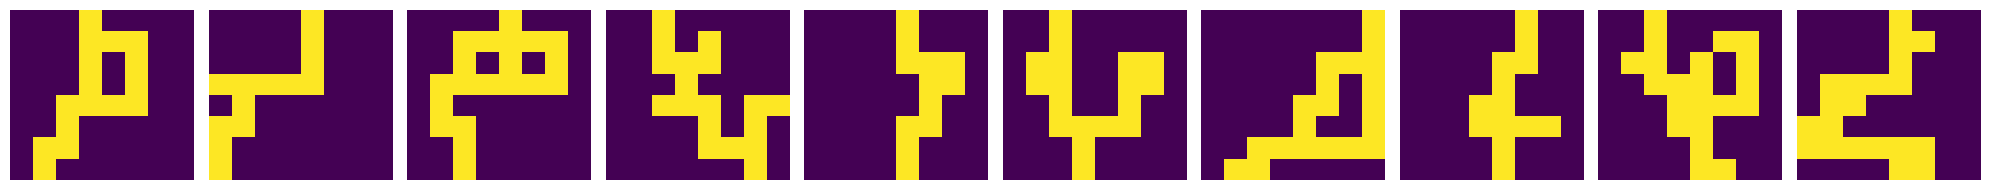

In [ ]:
###function to visualise a subset
def plot_dataset_subset(dataset, subset_size=10):
    fig, axes = plt.subplots(1, subset_size, figsize=(subset_size * 2, 2))
    for i in range(subset_size):
        ax = axes[i]
        ###Squeeze to remove the channel dimension for visualization
        ax.imshow(dataset[i].squeeze(), cmap='viridis', aspect='auto')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_dataset_subset(dataset_reshaped, subset_size=10)


##Augmenting the Dataset

In [ ]:
###Function to augment the dataset - Rotate and flip

def augment_dataset(dataset):
    augmented_data = []

    for img in dataset:
        #### Original image
        augmented_data.append(img)

        #### Flip horizontally
        augmented_data.append(np.flip(img, axis=1))

        #### Flip vertically
        augmented_data.append(np.flip(img, axis=0))

        #### Rotate 90 degrees
        augmented_data.append(np.rot90(img, k=1))

        #### Rotate 180 degrees
        augmented_data.append(np.rot90(img, k=2))

        #### Rotate 270 degrees
        augmented_data.append(np.rot90(img, k=3))

    return np.array(augmented_data)

augmented_dataset = augment_dataset(dataset_reshaped)


In [ ]:
## Verifying the shape of the augmented dataset
print(f"Augmented dataset shape: {augmented_dataset.shape}")


Augmented dataset shape: (1518, 8, 8, 1)


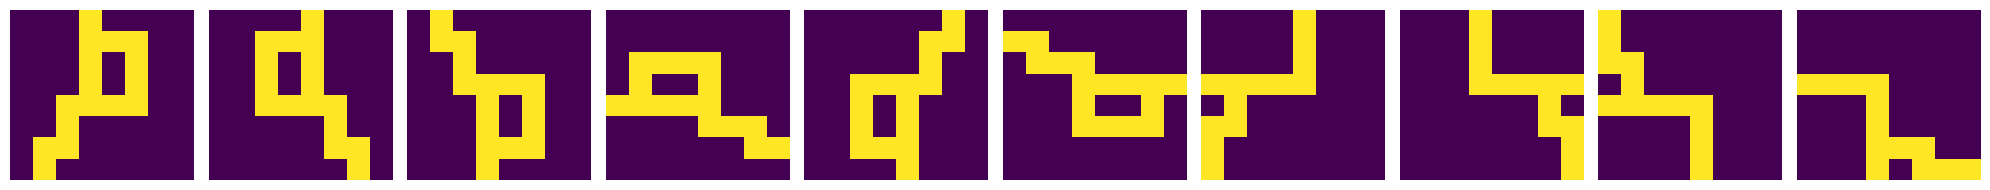

In [ ]:
### Function to plot a subset of the augmented dataset
def plot_augmented_subset(dataset, subset_size=10):
    fig, axes = plt.subplots(1, subset_size, figsize=(subset_size * 2, 2))
    for i in range(subset_size):
        ax = axes[i]
        ###Squeeze to remove the channel dimension for visualization
        ax.imshow(dataset[i].squeeze(), cmap='viridis', aspect='auto')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_augmented_subset(augmented_dataset, subset_size=10)

##Split into Train and Test

In [ ]:
####Splitting into 80% -Train 20% -Test
train_data, test_data = train_test_split(augmented_dataset, test_size=0.2, random_state=42)

####Verifying shapes
print(f"Training dataset shape: {train_data.shape}")
print(f"Testing dataset shape: {test_data.shape}")


Training dataset shape: (1214, 8, 8, 1)
Testing dataset shape: (304, 8, 8, 1)


#Building GAN

##Model

In [ ]:
###Building Generator - Tried fine tuning, changing the parameters, so trying different set of discriminators and generators
def build_generator():
    model = Sequential()

    model.add(Dense(128, input_dim=100))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(8 * 8 * 1, activation='tanh'))
    model.add(Reshape((8, 8, 1)))

    return model

generator = build_generator()
generator.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 128)               12928     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 batch_normalization_7 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [ ]:
###Building Discriminator - Tried fine tuning, changing the parameters, so trying different set of discriminators and generators
def build_discriminator():
    model = Sequential()

    model.add(Flatten(input_shape=(8, 8, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_18 (Dense)            (None, 512)               33280     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_20 (Dense)            (None, 1)                 257       
                                                                 
Total params: 164865 (644.00 KB)
Trainable params: 164

In [ ]:
###Compiling the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])

###Making the discriminator not trainable when compiling the GAN model
discriminator.trainable = False

###Building and compiling the GAN model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

gan.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 8, 8, 1)           213952    
                                                                 
 sequential_7 (Sequential)   (None, 1)                 164865    
                                                                 
Total params: 378817 (1.45 MB)
Trainable params: 212160 (828.75 KB)
Non-trainable params: 166657 (651.00 KB)
_________________________________________________________________


##Train1 - w/ early stopping

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive

tf.random.set_seed(42)
np.random.seed(42)

epochs = 10000
batch_size = 32

###Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

###Define strategy first
strategy = tf.distribute.MirroredStrategy() # Or any other strategy you want to use

###Building and compiling models within the strategy scope
with strategy.scope():
    def build_discriminator():
        model = Sequential([
            Flatten(input_shape=(8, 8, 1)),
            Dense(512),
            LeakyReLU(alpha=0.01),
            Dense(256),
            LeakyReLU(alpha=0.01),
            Dense(1, activation='sigmoid')
        ])
        model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), metrics=['accuracy'])
        return model

    def build_generator():
        model = Sequential([
            Dense(128, input_dim=100),
            LeakyReLU(alpha=0.01),
            BatchNormalization(momentum=0.8),
            Dense(256),
            LeakyReLU(alpha=0.01),
            BatchNormalization(momentum=0.8),
            Dense(512),
            LeakyReLU(alpha=0.01),
            BatchNormalization(momentum=0.8),
            Dense(8 * 8 * 1, activation='tanh'),
            Reshape((8, 8, 1))
        ])
        return model

    ###Instantiating models
    generator = build_generator()
    discriminator = build_discriminator()

    ###Make the discriminator not trainable when compiling the GAN model
    discriminator.trainable = False

    ###Build and compile the GAN model
    gan = Sequential([generator, discriminator])
    gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))


with strategy.scope():
    ###Model checkpoint callback (now defined within strategy scope)
    checkpoint_path = '/content/drive/My Drive/gan_checkpoint.h5'
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')



###Training loop
for epoch in range(epochs):
    ###Train discriminator
    real_images = np.random.rand(batch_size, 8, 8, 1)  # Replace with actual data
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = generator.predict(noise)

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    ###Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    ###Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

    ###Check for early stopping and save checkpoints
    if epoch > 0 and epoch % 500 == 0:
        ###Evaluate on a small validation set (e.g., 10 samples)
        val_noise = np.random.normal(0, 1, (10, 100))
        val_generated_images = generator.predict(val_noise)
        val_loss = discriminator.evaluate(val_generated_images, np.zeros((10, 1)), verbose=0)
        print(f"Epoch {epoch}, Validation Loss: {val_loss[0]}")

        ###Update early stopping with current validation loss
        if early_stopping.model:
            early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss[0]})

        ###Check if early stopping criterion is met
        if early_stopping and early_stopping.stopped_epoch > 0:
            print(f"Early stopping at epoch {epoch}")
            break


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 133ms/step
Epoch 5100, Discriminator Loss: 0.6981137990951538, Generator Loss: 0.717069685459137
1/1 [==============================] - 1s 1s/step
Epoch 5200, Discriminator Loss: 0.691847026348114, Generator Loss: 0.6830200552940369
1/1 [==============================] - 0s 126ms/step
Epoch 5300, Discriminator Loss: 0.6934292912483215, Generator Loss: 0.7057609558105469
1/1 [==============================] - 0s 105ms/step
Epoch 5400, Discriminator Loss: 0.687818169593811, Generator Loss: 0.7173901796340942
1/1 [==============================] - 0s 100ms/step
Epoch 5500, Discriminator Loss: 0.7025542557239532, Generator Loss: 0.6947170495986938
1/1 [==============================] - 0s 111ms/step
Epoch 5500, Validation Loss: 0.7141355276107788
1/1 [==============================] - 0s 151ms/step
Epoch 5600, Discriminator Loss: 0.6984997093677521, Generator Loss: 0.6992861032485962
1/1 [=========

###Visualize

1/1 [==============================] - 0s 245ms/step


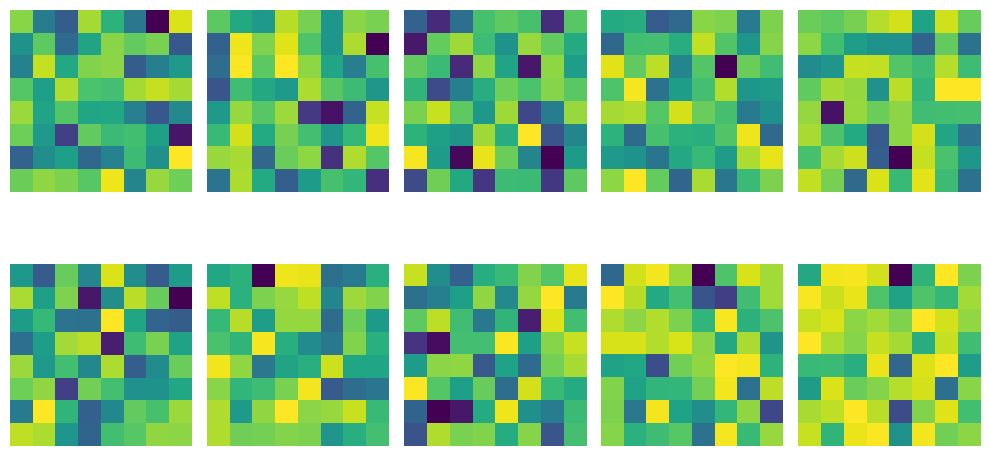

In [ ]:
###Visualising the result image on trained generator
import matplotlib.pyplot as plt
import numpy as np

num_images = 10

noise = np.random.normal(0, 1, (num_images, 100))  # Assuming input dimension is 100

###Generate images using the generator
generated_images = generator.predict(noise)

###Plot the generated images
plt.figure(figsize=(10, 6))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='viridis')  # Assuming grayscale output
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
###Saving the generator and discriminator models
generator.save('/content/drive/My Drive/generator_model.h5')
discriminator.save('/content/drive/My Drive/discriminator_model.h5')

###The above is version 1 - will load again and train further

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Train2 - w/ early stopping

In [ ]:
from tensorflow.keras.models import load_model

###Loading the generator and discriminator models
loaded_generator = load_model('/content/drive/My Drive/generator_model.h5')
loaded_discriminator = load_model('/content/drive/My Drive/discriminator_model.h5')

###Make the discriminator not trainable when compiling the GAN model
loaded_discriminator.trainable = False

###Rebuilding and compiling the GAN model using the loaded generator and discriminator
loaded_gan = Sequential([loaded_generator, loaded_discriminator])
loaded_gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))



In [ ]:
###Number of additional epochs
additional_epochs = 10000

###Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



###Training loop
for epoch in range(additional_epochs):
    ###Train discriminator
    real_images = np.random.rand(batch_size, 8, 8, 1)  # Replace with actual data
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = loaded_generator.predict(noise)

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = loaded_discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = loaded_discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    ###Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = loaded_gan.train_on_batch(noise, np.ones((batch_size, 1)))

    ###Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

    ###Check for early stopping and save checkpoints
    if epoch > 0 and epoch % 500 == 0:
        ###Evaluate on a small validation set (e.g., 10 samples)
        val_noise = np.random.normal(0, 1, (10, 100))
        val_generated_images = loaded_generator.predict(val_noise)
        val_loss = loaded_discriminator.evaluate(val_generated_images, np.zeros((10, 1)), verbose=0)
        print(f"Epoch {epoch}, Validation Loss: {val_loss[0]}")

        ###Update early stopping with current validation loss
        if early_stopping.model:
            early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss[0]})


        checkpoint_path = '/content/drive/My Drive/gan_additional_checkpoint.h5'
        model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

        ###Check if early stopping criterion is met
        if early_stopping and early_stopping.stopped_epoch > 0:
            print(f"Early stopping at epoch {epoch}")
            break


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Epoch 5100, Discriminator Loss: 0.9544247984886169, Generator Loss: 0.34182214736938477
1/1 [==============================] - 0s 32ms/step
Epoch 5200, Discriminator Loss: 0.9477484226226807, Generator Loss: 0.34663599729537964
1/1 [==============================] - 0s 43ms/step
Epoch 5300, Discriminator Loss: 0.9509316086769104, Generator Loss: 0.3440408408641815
1/1 [==============================] - 0s 30ms/step
Epoch 5400, Discriminator Loss: 0.9522119164466858, Generator Loss: 0.3448370099067688
1/1 [==============================] - 0s 29ms/step
Epoch 5500, Discriminator Loss: 0.9542787671089172, Generator Loss: 0.3441317677497864
1/1 [==============================] - 0s 24ms/step
Epoch 5500, Validation Loss: 1.2453471422195435
1/1 [==============================] - 0s 33ms/step
Epoch 5600, Discriminator Loss: 0.9552188515663147, Generator Loss: 0.3462789058685303
1/1 [========

In [ ]:
###Saving the generator and discriminator models
generator.save('/content/drive/My Drive/generator_model_final.h5')
discriminator.save('/content/drive/My Drive/discriminator_model_final.h5')

###V2

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


###Visualize

1/1 [==============================] - 0s 127ms/step


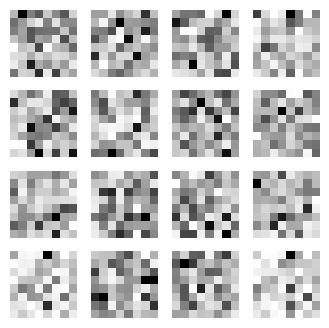

In [ ]:
###Visulaizing the result
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input):
    predictions = model.predict(test_input)

    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.show()

noise = np.random.normal(0, 1, (16, 100))
generate_and_save_images(generator, 10000, noise)


##Train3 - w/ early stopping

In [ ]:
from tensorflow.keras.models import load_model

###Load the generator and discriminator models
loaded_generator = load_model('/content/drive/My Drive/generator_model_final.h5')
loaded_discriminator = load_model('/content/drive/My Drive/discriminator_model_final.h5')

###Make the discriminator not trainable when compiling the GAN model
loaded_discriminator.trainable = False

###Rebuild and compile the GAN model using the loaded generator and discriminator
loaded_gan = Sequential([loaded_generator, loaded_discriminator])
loaded_gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

###Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

###Model checkpoint callback
checkpoint_path = '/content/drive/My Drive/gan_additional_checkpoint_final.h5'
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')

###Number of additional epochs
additional_epochs = 1500

###Training loop
for epoch in range(additional_epochs):
    # Train discriminator
    real_images = np.random.rand(batch_size, 8, 8, 1)  # Replace with actual data
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = loaded_generator.predict(noise)

    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = loaded_discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = loaded_discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = loaded_gan.train_on_batch(noise, np.ones((batch_size, 1)))

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

    # Check for early stopping and save checkpoints
    if epoch > 0 and epoch % 500 == 0:
        # Evaluate on a small validation set (e.g., 10 samples)
        val_noise = np.random.normal(0, 1, (10, 100))
        val_generated_images = loaded_generator.predict(val_noise)
        val_loss = loaded_discriminator.evaluate(val_generated_images, np.zeros((10, 1)), verbose=0)
        print(f"Epoch {epoch}, Validation Loss: {val_loss[0]}")

        # Update early stopping with current validation loss
        if early_stopping.model:
            early_stopping.on_epoch_end(epoch, logs={'val_loss': val_loss[0]})

        # Check if early stopping criterion is met
        if early_stopping and early_stopping.stopped_epoch > 0:
            print(f"Early stopping at epoch {epoch}")
            break


1/1 [==============================] - 1s 700ms/step
Epoch 0, Discriminator Loss: 0.6811468303203583, Generator Loss: 0.6915168762207031
1/1 [==============================] - 0s 22ms/step
Epoch 100, Discriminator Loss: 0.7916666269302368, Generator Loss: 0.5522487163543701
1/1 [==============================] - 0s 22ms/step
Epoch 200, Discriminator Loss: 0.8370078802108765, Generator Loss: 0.4664459824562073
1/1 [==============================] - 0s 21ms/step
Epoch 300, Discriminator Loss: 0.8581980764865875, Generator Loss: 0.47463056445121765
1/1 [==============================] - 0s 29ms/step
Epoch 400, Discriminator Loss: 0.8727079033851624, Generator Loss: 0.448972225189209
1/1 [==============================] - 0s 25ms/step
Epoch 500, Discriminator Loss: 0.8781605064868927, Generator Loss: 0.41394370794296265
1/1 [==============================] - 0s 148ms/step
Epoch 500, Validation Loss: 1.0850566625595093
1/1 [==============================] - 0s 23ms/step
Epoch 600, Discrimin

###Visualize

1/1 [==============================] - 0s 297ms/step


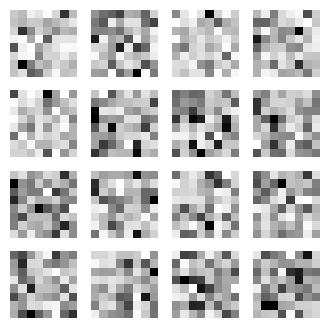

In [ ]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input):
    predictions = model.predict(test_input)

    predictions = (predictions + 1) / 2.0

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(f'generated_images_epoch_{epoch}.png')
    plt.show()

noise = np.random.normal(0, 1, (16, 100))
current_epoch = 10000  # Set this to your current epoch number
generate_and_save_images(generator, current_epoch, noise)


In [ ]:
### Save the updated generator and discriminator models after additional training
loaded_generator.save('/content/drive/My Drive/generator_model_final_updated.h5')
loaded_discriminator.save('/content/drive/My Drive/discriminator_model_final_updated.h5')

###V3 - not much training, only 1500 epochs

##Train4 - w/o early stopping final train

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

### Load the saved models v3
loaded_generator = load_model('/content/drive/My Drive/generator_model_final_updated.h5')
loaded_discriminator = load_model('/content/drive/My Drive/discriminator_model_final_updated.h5')


In [ ]:
from tensorflow.keras.optimizers import Adam

###Make the discriminator non-trainable when training the GAN
loaded_discriminator.trainable = False

###Build and compile the GAN model with loaded models
gan = tf.keras.Sequential([loaded_generator, loaded_discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001, beta_1=0.5))


1/1 [==============================] - 0s 234ms/step
Epoch 0, Discriminator Loss: 0.6840803325176239, Generator Loss: 0.7085205316543579
1/1 [==============================] - 0s 23ms/step
Epoch 100, Discriminator Loss: 0.678617924451828, Generator Loss: 0.5497976541519165
1/1 [==============================] - 0s 24ms/step
Epoch 200, Discriminator Loss: 0.6841820180416107, Generator Loss: 0.48717355728149414
1/1 [==============================] - 0s 24ms/step
Epoch 300, Discriminator Loss: 0.680074155330658, Generator Loss: 0.4520982503890991
1/1 [==============================] - 0s 24ms/step
Epoch 400, Discriminator Loss: 0.6895081400871277, Generator Loss: 0.467851459980011
1/1 [==============================] - 0s 23ms/step
Epoch 500, Discriminator Loss: 0.6841245889663696, Generator Loss: 0.4121630787849426


1/1 [==============================] - 0s 148ms/step


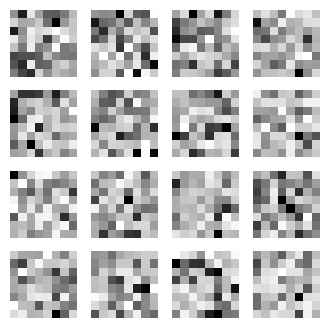

1/1 [==============================] - 0s 27ms/step
Epoch 500, Validation Loss: 0.4099699556827545
1/1 [==============================] - 0s 21ms/step
Epoch 600, Discriminator Loss: 0.6852661371231079, Generator Loss: 0.4047278165817261
1/1 [==============================] - 0s 24ms/step
Epoch 700, Discriminator Loss: 0.6854057908058167, Generator Loss: 0.3930332660675049
1/1 [==============================] - 0s 22ms/step
Epoch 800, Discriminator Loss: 0.6863951086997986, Generator Loss: 0.39075756072998047
1/1 [==============================] - 0s 20ms/step
Epoch 900, Discriminator Loss: 0.6872894763946533, Generator Loss: 0.3837249279022217
1/1 [==============================] - 0s 31ms/step
Epoch 1000, Discriminator Loss: 0.6756784319877625, Generator Loss: 0.4073818325996399


1/1 [==============================] - 0s 36ms/step


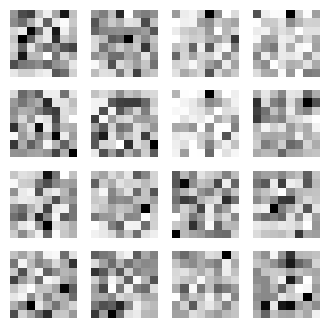

1/1 [==============================] - 0s 33ms/step
Epoch 1000, Validation Loss: 0.38173308968544006
1/1 [==============================] - 0s 43ms/step
Epoch 1100, Discriminator Loss: 0.6844269335269928, Generator Loss: 0.37696194648742676
1/1 [==============================] - 0s 47ms/step
Epoch 1200, Discriminator Loss: 0.6822194457054138, Generator Loss: 0.3712320029735565
1/1 [==============================] - 0s 31ms/step
Epoch 1300, Discriminator Loss: 0.6836623847484589, Generator Loss: 0.36722323298454285
1/1 [==============================] - 0s 36ms/step
Epoch 1400, Discriminator Loss: 0.6772653460502625, Generator Loss: 0.38784411549568176
1/1 [==============================] - 0s 29ms/step
Epoch 1500, Discriminator Loss: 0.6887611150741577, Generator Loss: 0.35969996452331543


1/1 [==============================] - 0s 33ms/step


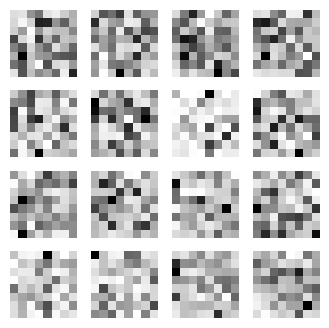

1/1 [==============================] - 0s 33ms/step
Epoch 1500, Validation Loss: 0.35853809118270874
1/1 [==============================] - 0s 26ms/step
Epoch 1600, Discriminator Loss: 0.6887015104293823, Generator Loss: 0.3616514801979065
1/1 [==============================] - 0s 28ms/step
Epoch 1700, Discriminator Loss: 0.6837059557437897, Generator Loss: 0.3642113208770752
1/1 [==============================] - 0s 26ms/step
Epoch 1800, Discriminator Loss: 0.6934281587600708, Generator Loss: 0.3554624021053314
1/1 [==============================] - 0s 29ms/step
Epoch 1900, Discriminator Loss: 0.682064414024353, Generator Loss: 0.35538288950920105
1/1 [==============================] - 0s 28ms/step
Epoch 2000, Discriminator Loss: 0.6774639189243317, Generator Loss: 0.3549318313598633


1/1 [==============================] - 0s 41ms/step


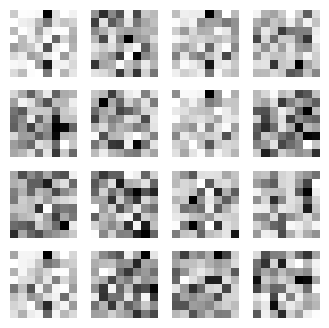

1/1 [==============================] - 0s 35ms/step
Epoch 2000, Validation Loss: 0.3512950837612152
1/1 [==============================] - 0s 47ms/step
Epoch 2100, Discriminator Loss: 0.675676554441452, Generator Loss: 0.35729265213012695
1/1 [==============================] - 0s 35ms/step
Epoch 2200, Discriminator Loss: 0.6802255809307098, Generator Loss: 0.35589903593063354
1/1 [==============================] - 0s 34ms/step
Epoch 2300, Discriminator Loss: 0.6712220013141632, Generator Loss: 0.35394614934921265
1/1 [==============================] - 0s 37ms/step
Epoch 2400, Discriminator Loss: 0.6772218346595764, Generator Loss: 0.353423535823822
1/1 [==============================] - 0s 37ms/step
Epoch 2500, Discriminator Loss: 0.6834183037281036, Generator Loss: 0.35327303409576416


1/1 [==============================] - 0s 37ms/step


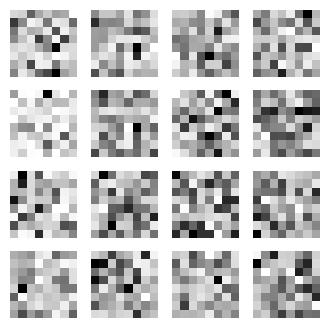

1/1 [==============================] - 0s 37ms/step
Epoch 2500, Validation Loss: 0.3560897409915924
1/1 [==============================] - 0s 47ms/step
Epoch 2600, Discriminator Loss: 0.6793157756328583, Generator Loss: 0.3566845655441284
1/1 [==============================] - 0s 45ms/step
Epoch 2700, Discriminator Loss: 0.6808470189571381, Generator Loss: 0.35305601358413696
1/1 [==============================] - 0s 31ms/step
Epoch 2800, Discriminator Loss: 0.6803233623504639, Generator Loss: 0.35473719239234924
1/1 [==============================] - 0s 32ms/step
Epoch 2900, Discriminator Loss: 0.685104638338089, Generator Loss: 0.34897783398628235
1/1 [==============================] - 0s 34ms/step
Epoch 3000, Discriminator Loss: 0.6874423623085022, Generator Loss: 0.34942811727523804


1/1 [==============================] - 0s 33ms/step


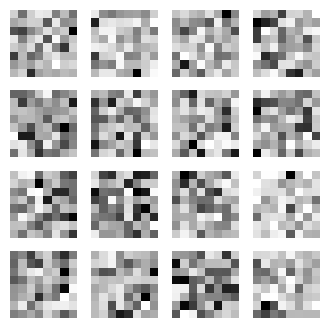

1/1 [==============================] - 0s 32ms/step
Epoch 3000, Validation Loss: 0.3444986343383789
1/1 [==============================] - 0s 26ms/step
Epoch 3100, Discriminator Loss: 0.682278037071228, Generator Loss: 0.35883861780166626
1/1 [==============================] - 0s 29ms/step
Epoch 3200, Discriminator Loss: 0.6690279543399811, Generator Loss: 0.3535532057285309
1/1 [==============================] - 0s 32ms/step
Epoch 3300, Discriminator Loss: 0.6805352866649628, Generator Loss: 0.35286760330200195
1/1 [==============================] - 0s 37ms/step
Epoch 3400, Discriminator Loss: 0.6855789422988892, Generator Loss: 0.3497419059276581
1/1 [==============================] - 0s 45ms/step
Epoch 3500, Discriminator Loss: 0.6882108151912689, Generator Loss: 0.3546423316001892


1/1 [==============================] - 0s 27ms/step


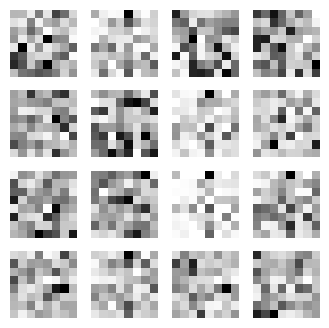

1/1 [==============================] - 0s 27ms/step
Epoch 3500, Validation Loss: 0.34901130199432373
1/1 [==============================] - 0s 23ms/step
Epoch 3600, Discriminator Loss: 0.6923342347145081, Generator Loss: 0.34488964080810547
1/1 [==============================] - 0s 25ms/step
Epoch 3700, Discriminator Loss: 0.684112161397934, Generator Loss: 0.3493083119392395
1/1 [==============================] - 0s 23ms/step
Epoch 3800, Discriminator Loss: 0.6822395324707031, Generator Loss: 0.36079859733581543
1/1 [==============================] - 0s 31ms/step
Epoch 3900, Discriminator Loss: 0.6815248727798462, Generator Loss: 0.36611688137054443
1/1 [==============================] - 0s 36ms/step
Epoch 4000, Discriminator Loss: 0.6762374341487885, Generator Loss: 0.35891371965408325


1/1 [==============================] - 0s 37ms/step


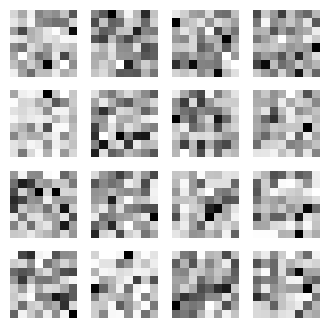

1/1 [==============================] - 0s 36ms/step
Epoch 4000, Validation Loss: 0.34721502661705017
1/1 [==============================] - 0s 63ms/step
Epoch 4100, Discriminator Loss: 0.691949188709259, Generator Loss: 0.3610225021839142
1/1 [==============================] - 0s 38ms/step
Epoch 4200, Discriminator Loss: 0.6913918256759644, Generator Loss: 0.35157811641693115
1/1 [==============================] - 0s 38ms/step
Epoch 4300, Discriminator Loss: 0.6797595620155334, Generator Loss: 0.3493940830230713
1/1 [==============================] - 0s 33ms/step
Epoch 4400, Discriminator Loss: 0.6798319816589355, Generator Loss: 0.34700340032577515
1/1 [==============================] - 0s 30ms/step
Epoch 4500, Discriminator Loss: 0.6825893819332123, Generator Loss: 0.348965585231781


1/1 [==============================] - 0s 36ms/step


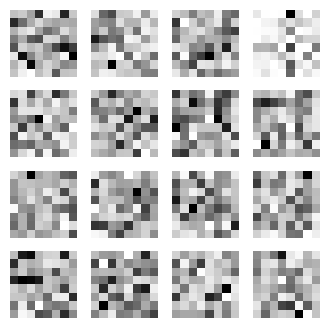

1/1 [==============================] - 0s 46ms/step
Epoch 4500, Validation Loss: 0.35347360372543335
1/1 [==============================] - 0s 27ms/step
Epoch 4600, Discriminator Loss: 0.6827698051929474, Generator Loss: 0.3549070954322815
1/1 [==============================] - 0s 29ms/step
Epoch 4700, Discriminator Loss: 0.6876455545425415, Generator Loss: 0.34941962361335754
1/1 [==============================] - 0s 27ms/step
Epoch 4800, Discriminator Loss: 0.6789498031139374, Generator Loss: 0.34599563479423523
1/1 [==============================] - 0s 25ms/step
Epoch 4900, Discriminator Loss: 0.681575208902359, Generator Loss: 0.3435048460960388
1/1 [==============================] - 0s 24ms/step
Epoch 5000, Discriminator Loss: 0.690923273563385, Generator Loss: 0.3502320647239685


1/1 [==============================] - 0s 28ms/step


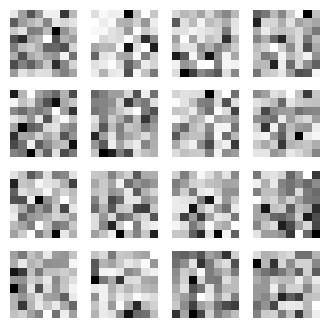

1/1 [==============================] - 0s 25ms/step
Epoch 5000, Validation Loss: 0.3467436134815216
1/1 [==============================] - 0s 42ms/step
Epoch 5100, Discriminator Loss: 0.6933831870555878, Generator Loss: 0.34705013036727905
1/1 [==============================] - 0s 38ms/step
Epoch 5200, Discriminator Loss: 0.680643230676651, Generator Loss: 0.3465166389942169
1/1 [==============================] - 0s 32ms/step
Epoch 5300, Discriminator Loss: 0.6736606657505035, Generator Loss: 0.34474247694015503
1/1 [==============================] - 0s 30ms/step
Epoch 5400, Discriminator Loss: 0.6738025546073914, Generator Loss: 0.3481665253639221
1/1 [==============================] - 0s 39ms/step
Epoch 5500, Discriminator Loss: 0.6824591159820557, Generator Loss: 0.3443933129310608


1/1 [==============================] - 0s 38ms/step


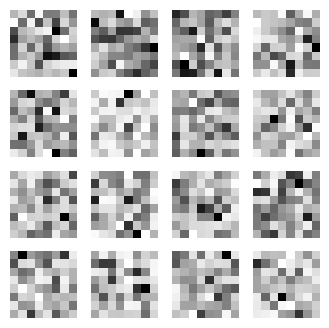

1/1 [==============================] - 0s 36ms/step
Epoch 5500, Validation Loss: 0.3428916931152344
1/1 [==============================] - 0s 36ms/step
Epoch 5600, Discriminator Loss: 0.6788237988948822, Generator Loss: 0.3479066491127014
1/1 [==============================] - 0s 43ms/step
Epoch 5700, Discriminator Loss: 0.684426873922348, Generator Loss: 0.35052207112312317
1/1 [==============================] - 0s 31ms/step
Epoch 5800, Discriminator Loss: 0.684971034526825, Generator Loss: 0.3515927493572235
1/1 [==============================] - 0s 29ms/step
Epoch 5900, Discriminator Loss: 0.6867694854736328, Generator Loss: 0.34900686144828796
1/1 [==============================] - 0s 33ms/step
Epoch 6000, Discriminator Loss: 0.6853908598423004, Generator Loss: 0.353046715259552


1/1 [==============================] - 0s 49ms/step


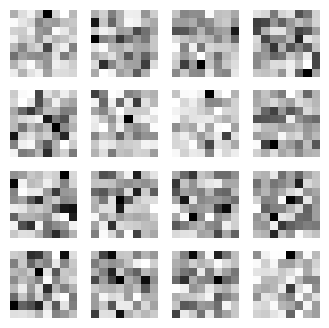

1/1 [==============================] - 0s 34ms/step
Epoch 6000, Validation Loss: 0.3490889072418213
1/1 [==============================] - 0s 30ms/step
Epoch 6100, Discriminator Loss: 0.677870512008667, Generator Loss: 0.35663750767707825
1/1 [==============================] - 0s 43ms/step
Epoch 6200, Discriminator Loss: 0.6882327198982239, Generator Loss: 0.35414665937423706
1/1 [==============================] - 0s 39ms/step
Epoch 6300, Discriminator Loss: 0.6877415478229523, Generator Loss: 0.3458794057369232
1/1 [==============================] - 0s 42ms/step
Epoch 6400, Discriminator Loss: 0.6855754256248474, Generator Loss: 0.3724275231361389
1/1 [==============================] - 0s 44ms/step
Epoch 6500, Discriminator Loss: 0.6811049580574036, Generator Loss: 0.35265153646469116


1/1 [==============================] - 0s 29ms/step


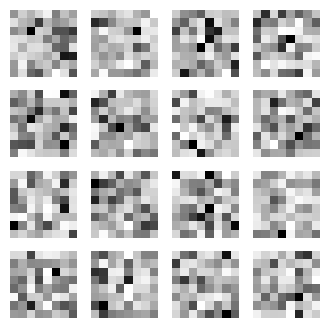

1/1 [==============================] - 0s 26ms/step
Epoch 6500, Validation Loss: 0.3474368453025818
1/1 [==============================] - 0s 22ms/step
Epoch 6600, Discriminator Loss: 0.6801006197929382, Generator Loss: 0.343320369720459
1/1 [==============================] - 0s 22ms/step
Epoch 6700, Discriminator Loss: 0.6887529492378235, Generator Loss: 0.34260016679763794
1/1 [==============================] - 0s 24ms/step
Epoch 6800, Discriminator Loss: 0.6860921084880829, Generator Loss: 0.3518165349960327
1/1 [==============================] - 0s 32ms/step
Epoch 6900, Discriminator Loss: 0.684723436832428, Generator Loss: 0.3519577383995056
1/1 [==============================] - 0s 33ms/step
Epoch 7000, Discriminator Loss: 0.6750928163528442, Generator Loss: 0.34591439366340637


1/1 [==============================] - 0s 35ms/step


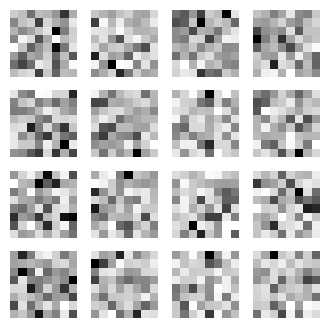

1/1 [==============================] - 0s 44ms/step
Epoch 7000, Validation Loss: 0.3599851131439209
1/1 [==============================] - 0s 44ms/step
Epoch 7100, Discriminator Loss: 0.692001223564148, Generator Loss: 0.3479917049407959
1/1 [==============================] - 0s 34ms/step
Epoch 7200, Discriminator Loss: 0.6817485690116882, Generator Loss: 0.34421300888061523
1/1 [==============================] - 0s 31ms/step
Epoch 7300, Discriminator Loss: 0.6876899302005768, Generator Loss: 0.3471127152442932
1/1 [==============================] - 0s 29ms/step
Epoch 7400, Discriminator Loss: 0.6744703948497772, Generator Loss: 0.3479873239994049
1/1 [==============================] - 0s 28ms/step
Epoch 7500, Discriminator Loss: 0.6751969456672668, Generator Loss: 0.3460935652256012


1/1 [==============================] - 0s 31ms/step


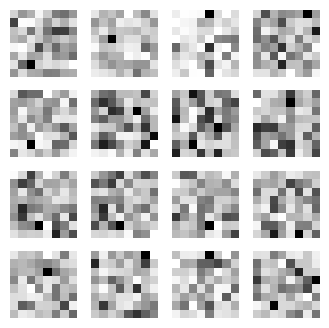

1/1 [==============================] - 0s 54ms/step
Epoch 7500, Validation Loss: 0.3404054641723633
1/1 [==============================] - 0s 38ms/step
Epoch 7600, Discriminator Loss: 0.6839393377304077, Generator Loss: 0.3451000452041626
1/1 [==============================] - 0s 45ms/step
Epoch 7700, Discriminator Loss: 0.6814960837364197, Generator Loss: 0.3482663631439209
1/1 [==============================] - 0s 24ms/step
Epoch 7800, Discriminator Loss: 0.6745340526103973, Generator Loss: 0.3439709544181824
1/1 [==============================] - 0s 24ms/step
Epoch 7900, Discriminator Loss: 0.6763249039649963, Generator Loss: 0.3443770408630371
1/1 [==============================] - 0s 35ms/step
Epoch 8000, Discriminator Loss: 0.684552788734436, Generator Loss: 0.34141814708709717


1/1 [==============================] - 0s 28ms/step


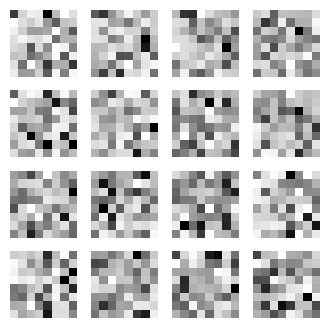

1/1 [==============================] - 0s 28ms/step
Epoch 8000, Validation Loss: 0.3391188979148865
1/1 [==============================] - 0s 24ms/step
Epoch 8100, Discriminator Loss: 0.6877996921539307, Generator Loss: 0.35888800024986267
1/1 [==============================] - 0s 22ms/step
Epoch 8200, Discriminator Loss: 0.6698629558086395, Generator Loss: 0.34618720412254333
1/1 [==============================] - 0s 34ms/step
Epoch 8300, Discriminator Loss: 0.6906777620315552, Generator Loss: 0.34217238426208496
1/1 [==============================] - 0s 59ms/step
Epoch 8400, Discriminator Loss: 0.6796405911445618, Generator Loss: 0.34291595220565796
1/1 [==============================] - 0s 29ms/step
Epoch 8500, Discriminator Loss: 0.6898354291915894, Generator Loss: 0.3418262004852295


1/1 [==============================] - 0s 39ms/step


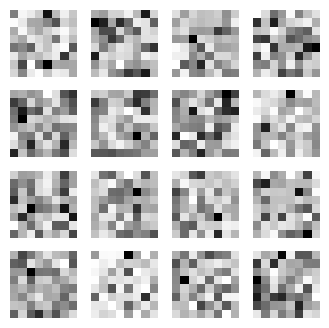

1/1 [==============================] - 0s 34ms/step
Epoch 8500, Validation Loss: 0.33889153599739075
1/1 [==============================] - 0s 34ms/step
Epoch 8600, Discriminator Loss: 0.6933200359344482, Generator Loss: 0.3418389558792114
1/1 [==============================] - 0s 34ms/step
Epoch 8700, Discriminator Loss: 0.6918390393257141, Generator Loss: 0.3423614501953125
1/1 [==============================] - 0s 42ms/step
Epoch 8800, Discriminator Loss: 0.6812774240970612, Generator Loss: 0.34611427783966064
1/1 [==============================] - 0s 31ms/step
Epoch 8900, Discriminator Loss: 0.6921018660068512, Generator Loss: 0.3460147976875305
1/1 [==============================] - 0s 34ms/step
Epoch 9000, Discriminator Loss: 0.685535728931427, Generator Loss: 0.3435710072517395


1/1 [==============================] - 0s 35ms/step


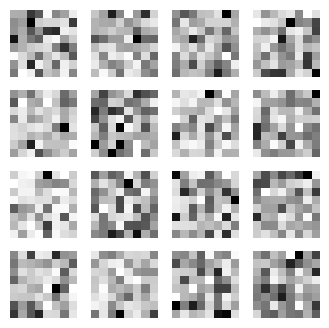

1/1 [==============================] - 0s 38ms/step
Epoch 9000, Validation Loss: 0.3438035845756531
1/1 [==============================] - 0s 26ms/step
Epoch 9100, Discriminator Loss: 0.6852400600910187, Generator Loss: 0.34582239389419556
1/1 [==============================] - 0s 30ms/step
Epoch 9200, Discriminator Loss: 0.6837709546089172, Generator Loss: 0.3417871594429016
1/1 [==============================] - 0s 26ms/step
Epoch 9300, Discriminator Loss: 0.6776227951049805, Generator Loss: 0.3457251191139221
1/1 [==============================] - 0s 34ms/step
Epoch 9400, Discriminator Loss: 0.6866326630115509, Generator Loss: 0.3420353829860687
1/1 [==============================] - 0s 35ms/step
Epoch 9500, Discriminator Loss: 0.6832277178764343, Generator Loss: 0.3427993953227997


1/1 [==============================] - 0s 44ms/step


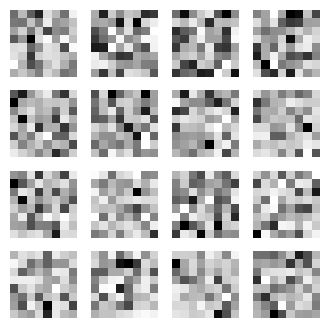

1/1 [==============================] - 0s 50ms/step
Epoch 9500, Validation Loss: 0.3407585024833679
1/1 [==============================] - 0s 27ms/step
Epoch 9600, Discriminator Loss: 0.6805275678634644, Generator Loss: 0.3522651195526123
1/1 [==============================] - 0s 25ms/step
Epoch 9700, Discriminator Loss: 0.6871398985385895, Generator Loss: 0.3476489782333374
1/1 [==============================] - 0s 35ms/step
Epoch 9800, Discriminator Loss: 0.6892015635967255, Generator Loss: 0.34146222472190857
1/1 [==============================] - 0s 32ms/step
Epoch 9900, Discriminator Loss: 0.6790116727352142, Generator Loss: 0.34372156858444214
1/1 [==============================] - 0s 33ms/step
Epoch 10000, Discriminator Loss: 0.6798596084117889, Generator Loss: 0.34456825256347656


1/1 [==============================] - 0s 59ms/step


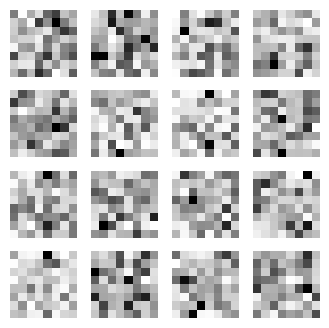

1/1 [==============================] - 0s 59ms/step
Epoch 10000, Validation Loss: 0.3438287377357483
1/1 [==============================] - 0s 34ms/step
Epoch 10100, Discriminator Loss: 0.6954240798950195, Generator Loss: 0.3436683416366577
1/1 [==============================] - 0s 33ms/step
Epoch 10200, Discriminator Loss: 0.6952739357948303, Generator Loss: 0.3477937579154968
1/1 [==============================] - 0s 30ms/step
Epoch 10300, Discriminator Loss: 0.6828972101211548, Generator Loss: 0.3419607877731323
1/1 [==============================] - 0s 34ms/step
Epoch 10400, Discriminator Loss: 0.6846836805343628, Generator Loss: 0.34452444314956665
1/1 [==============================] - 0s 48ms/step
Epoch 10500, Discriminator Loss: 0.6886234283447266, Generator Loss: 0.3546363115310669


1/1 [==============================] - 0s 49ms/step


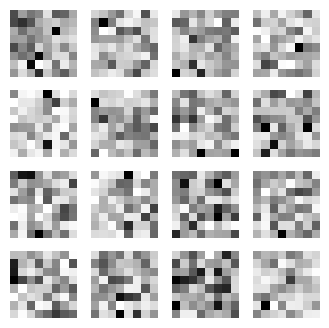

1/1 [==============================] - 0s 50ms/step
Epoch 10500, Validation Loss: 0.34224191308021545
1/1 [==============================] - 0s 27ms/step
Epoch 10600, Discriminator Loss: 0.6787031888961792, Generator Loss: 0.34375786781311035
1/1 [==============================] - 0s 27ms/step
Epoch 10700, Discriminator Loss: 0.6703810691833496, Generator Loss: 0.34431225061416626
1/1 [==============================] - 0s 24ms/step
Epoch 10800, Discriminator Loss: 0.6836071610450745, Generator Loss: 0.34346604347229004
1/1 [==============================] - 0s 44ms/step
Epoch 10900, Discriminator Loss: 0.6783948838710785, Generator Loss: 0.3433830738067627
1/1 [==============================] - 0s 25ms/step
Epoch 11000, Discriminator Loss: 0.6867072582244873, Generator Loss: 0.3396904468536377


1/1 [==============================] - 0s 27ms/step


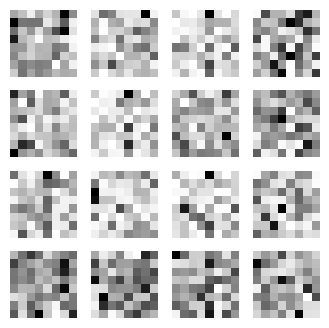

1/1 [==============================] - 0s 25ms/step
Epoch 11000, Validation Loss: 0.3389365077018738
1/1 [==============================] - 0s 23ms/step
Epoch 11100, Discriminator Loss: 0.6875381171703339, Generator Loss: 0.3492516577243805
1/1 [==============================] - 0s 25ms/step
Epoch 11200, Discriminator Loss: 0.6810528635978699, Generator Loss: 0.3413819372653961
1/1 [==============================] - 0s 48ms/step
Epoch 11300, Discriminator Loss: 0.687271237373352, Generator Loss: 0.3416907489299774
1/1 [==============================] - 0s 32ms/step
Epoch 11400, Discriminator Loss: 0.6860727667808533, Generator Loss: 0.3497686982154846
1/1 [==============================] - 0s 32ms/step
Epoch 11500, Discriminator Loss: 0.6879579126834869, Generator Loss: 0.34246253967285156


1/1 [==============================] - 0s 36ms/step


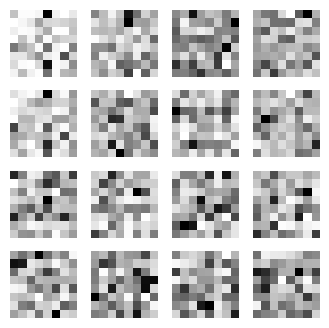

1/1 [==============================] - 0s 34ms/step
Epoch 11500, Validation Loss: 0.3429374396800995
1/1 [==============================] - 0s 31ms/step
Epoch 11600, Discriminator Loss: 0.6936782598495483, Generator Loss: 0.3402027189731598
1/1 [==============================] - 0s 57ms/step
Epoch 11700, Discriminator Loss: 0.6877769827842712, Generator Loss: 0.3432604670524597
1/1 [==============================] - 0s 34ms/step
Epoch 11800, Discriminator Loss: 0.6840706765651703, Generator Loss: 0.3440730571746826
1/1 [==============================] - 0s 30ms/step
Epoch 11900, Discriminator Loss: 0.6687299609184265, Generator Loss: 0.3491635322570801
1/1 [==============================] - 0s 29ms/step
Epoch 12000, Discriminator Loss: 0.6914843618869781, Generator Loss: 0.3404232859611511


1/1 [==============================] - 0s 43ms/step


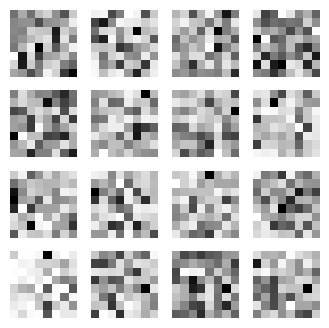

1/1 [==============================] - 0s 33ms/step
Epoch 12000, Validation Loss: 0.3376891314983368
1/1 [==============================] - 0s 38ms/step
Epoch 12100, Discriminator Loss: 0.6809686124324799, Generator Loss: 0.34423595666885376
1/1 [==============================] - 0s 41ms/step
Epoch 12200, Discriminator Loss: 0.6859711110591888, Generator Loss: 0.3393942713737488
1/1 [==============================] - 0s 25ms/step
Epoch 12300, Discriminator Loss: 0.6766683161258698, Generator Loss: 0.3419986963272095
1/1 [==============================] - 0s 26ms/step
Epoch 12400, Discriminator Loss: 0.6760549545288086, Generator Loss: 0.3402816653251648
1/1 [==============================] - 0s 26ms/step
Epoch 12500, Discriminator Loss: 0.6900255084037781, Generator Loss: 0.34352484345436096


1/1 [==============================] - 0s 36ms/step


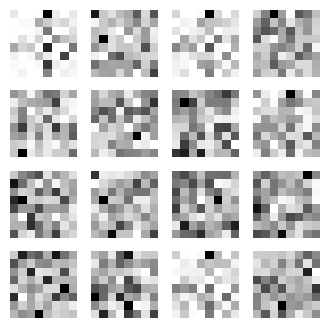

1/1 [==============================] - 0s 28ms/step
Epoch 12500, Validation Loss: 0.3383193612098694
1/1 [==============================] - 0s 21ms/step
Epoch 12600, Discriminator Loss: 0.6834088563919067, Generator Loss: 0.34148895740509033
1/1 [==============================] - 0s 29ms/step
Epoch 12700, Discriminator Loss: 0.6896103918552399, Generator Loss: 0.3439027965068817
1/1 [==============================] - 0s 59ms/step
Epoch 12800, Discriminator Loss: 0.670091450214386, Generator Loss: 0.3434050679206848
1/1 [==============================] - 0s 39ms/step
Epoch 12900, Discriminator Loss: 0.6906329691410065, Generator Loss: 0.3500612676143646
1/1 [==============================] - 0s 33ms/step
Epoch 13000, Discriminator Loss: 0.6849614977836609, Generator Loss: 0.34291738271713257


1/1 [==============================] - 0s 34ms/step


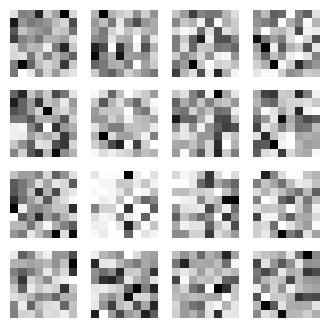

1/1 [==============================] - 0s 36ms/step
Epoch 13000, Validation Loss: 0.34088537096977234
1/1 [==============================] - 0s 35ms/step
Epoch 13100, Discriminator Loss: 0.6875507831573486, Generator Loss: 0.3465682566165924
1/1 [==============================] - 0s 48ms/step
Epoch 13200, Discriminator Loss: 0.6744741201400757, Generator Loss: 0.35213130712509155
1/1 [==============================] - 0s 32ms/step
Epoch 13300, Discriminator Loss: 0.6808077991008759, Generator Loss: 0.35018956661224365
1/1 [==============================] - 0s 39ms/step
Epoch 13400, Discriminator Loss: 0.6762576699256897, Generator Loss: 0.3442258834838867
1/1 [==============================] - 0s 31ms/step
Epoch 13500, Discriminator Loss: 0.6871502995491028, Generator Loss: 0.3424558937549591


1/1 [==============================] - 0s 37ms/step


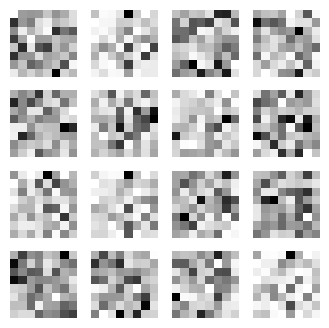

1/1 [==============================] - 0s 29ms/step
Epoch 13500, Validation Loss: 0.3384837508201599
1/1 [==============================] - 0s 49ms/step
Epoch 13600, Discriminator Loss: 0.6794768571853638, Generator Loss: 0.3494272828102112
1/1 [==============================] - 0s 56ms/step
Epoch 13700, Discriminator Loss: 0.6882972121238708, Generator Loss: 0.34062254428863525
1/1 [==============================] - 0s 37ms/step
Epoch 13800, Discriminator Loss: 0.6858421266078949, Generator Loss: 0.3434927463531494
1/1 [==============================] - 0s 27ms/step
Epoch 13900, Discriminator Loss: 0.6804040372371674, Generator Loss: 0.3453722596168518
1/1 [==============================] - 0s 27ms/step
Epoch 14000, Discriminator Loss: 0.6849170327186584, Generator Loss: 0.34035801887512207


1/1 [==============================] - 0s 26ms/step


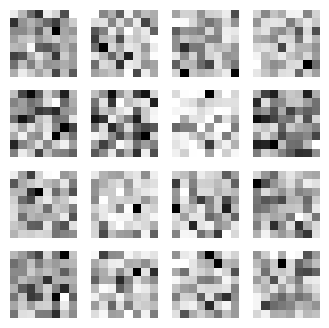

1/1 [==============================] - 0s 25ms/step
Epoch 14000, Validation Loss: 0.3361268937587738
1/1 [==============================] - 0s 23ms/step
Epoch 14100, Discriminator Loss: 0.6855570673942566, Generator Loss: 0.3412190079689026
1/1 [==============================] - 0s 26ms/step
Epoch 14200, Discriminator Loss: 0.6760620474815369, Generator Loss: 0.3390500545501709
1/1 [==============================] - 0s 43ms/step
Epoch 14300, Discriminator Loss: 0.7050794959068298, Generator Loss: 0.34235894680023193
1/1 [==============================] - 0s 48ms/step
Epoch 14400, Discriminator Loss: 0.685370534658432, Generator Loss: 0.34375226497650146
1/1 [==============================] - 0s 36ms/step
Epoch 14500, Discriminator Loss: 0.6846053004264832, Generator Loss: 0.34322434663772583


1/1 [==============================] - 0s 53ms/step


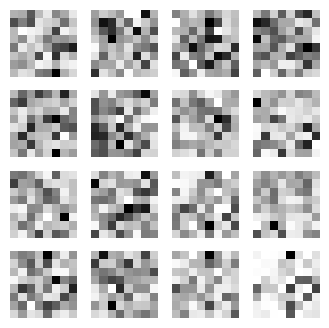

1/1 [==============================] - 0s 37ms/step
Epoch 14500, Validation Loss: 0.34556612372398376
1/1 [==============================] - 0s 40ms/step
Epoch 14600, Discriminator Loss: 0.6795852780342102, Generator Loss: 0.3389526605606079
1/1 [==============================] - 0s 32ms/step
Epoch 14700, Discriminator Loss: 0.6781495809555054, Generator Loss: 0.34360677003860474
1/1 [==============================] - 0s 52ms/step
Epoch 14800, Discriminator Loss: 0.6886036098003387, Generator Loss: 0.3487643003463745
1/1 [==============================] - 0s 32ms/step
Epoch 14900, Discriminator Loss: 0.6699564158916473, Generator Loss: 0.3409577012062073
1/1 [==============================] - 0s 26ms/step


In [ ]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

###Adjust training parameters as needed
epochs = 15000  ###Number of additional epochs to train
batch_size = 32

###Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

###Training loop
for epoch in range(epochs):
    ###Train discriminator with label smoothing
    real_images = np.random.rand(batch_size, 8, 8, 1)
    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_images = loaded_generator.predict(noise)

    real_labels = np.ones((batch_size, 1)) * 0.9
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = loaded_discriminator.train_on_batch(real_images, real_labels)
    d_loss_fake = loaded_discriminator.train_on_batch(fake_images, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    ###Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

    ###Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Discriminator Loss: {d_loss[0]}, Generator Loss: {g_loss}")

    ###Save model and generate images as before
    if epoch > 0 and epoch % 500 == 0:
        ###Save model checkpoint
        gan.save('/content/drive/My Drive/gan_checkpoint.h5')
        loaded_generator.save('/content/drive/My Drive/generator_model_updated.h5')
        loaded_discriminator.save('/content/drive/My Drive/discriminator_model_updated.h5')

        ###Generate and save images
        noise = np.random.normal(0, 1, (16, 100))
        current_epoch = epoch
        generate_and_save_images(loaded_generator, current_epoch, noise)

        ###Early stopping based on generator's loss on validation set
        val_noise = np.random.normal(0, 1, (10, 100))
        val_generated_images = loaded_generator.predict(val_noise)

        ###Evaluate the ENTIRE GAN model on validation data
        val_loss = gan.evaluate(val_noise, np.ones((10, 1)), verbose=0)

        print(f"Epoch {epoch}, Validation Loss: {val_loss}")

        if early_stopping.stopped_epoch > 0:
            print(f"Early stopping at epoch {epoch}")
            break

###Visualize

1/1 [==============================] - 0s 154ms/step


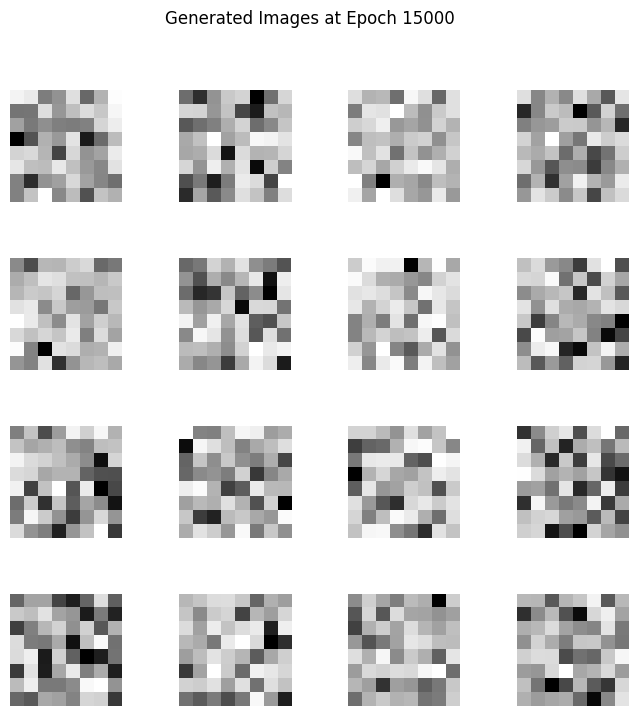

In [ ]:
import matplotlib.pyplot as plt

def generate_and_display_images(generator, epoch, noise):
    generated_images = generator.predict(noise)

    fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharex=True, sharey=True)
    fig.subplots_adjust(hspace=0.5, wspace=0.5)  # Adjust spacing

    cnt = 0
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(generated_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()
    plt.close()

val_noise = np.random.normal(0, 1, (16, 100))
generate_and_display_images(loaded_generator, epochs, val_noise)


In [ ]:
###Save the updated generator and discriminator models
generator_save_path = '/content/drive/My Drive/generator_model_final.h5'
discriminator_save_path = '/content/drive/My Drive/discriminator_model_final.h5'

loaded_generator.save(generator_save_path)
loaded_discriminator.save(discriminator_save_path)

print(f"Models saved successfully at:")
print(f"Generator: {generator_save_path}")
print(f"Discriminator: {discriminator_save_path}")


Models saved successfully at:
Generator: /content/drive/My Drive/generator_model_final.h5
Discriminator: /content/drive/My Drive/discriminator_model_final.h5


#Correction Algorithm

In [33]:
###Correction algorithm -
import numpy as np
from tensorflow.keras.models import load_model
from google.colab import drive

drive.mount('/content/drive')

loaded_generator = load_model('/content/drive/My Drive/generator_model_final.h5')

###Function to generate a single image
def generate_image(generator_model):
    ###Generate random noise as input to the generator
    noise = np.random.normal(0, 1, (1, 100))  # 1 image, 100-dimensional noise vector

    ###Generate image from noise
    generated_image = generator_model.predict(noise)

    return generated_image

###Generate an image using the loaded generator
generated_image = generate_image(loaded_generator)

###Ensure the shape of generated_image is (1, 8, 8, 1) or reshape if necessary
generated_image = generated_image.reshape((8, 8))  ###Reshape if needed, assuming it's grayscale


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1/1 [==============================] - 0s 135ms/step


1/1 [==============================] - 0s 38ms/step


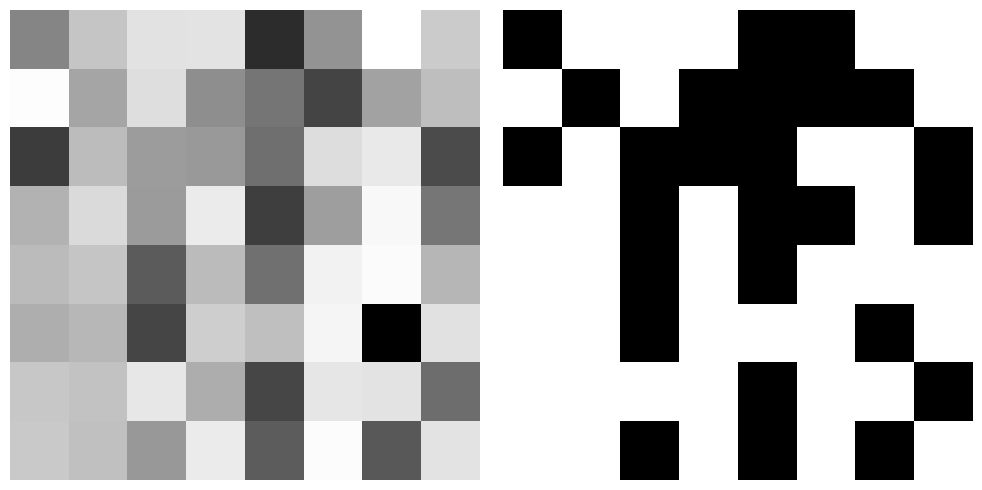

In [34]:
###Function to correct the image by thresholding
def correct_image(image, threshold_value=0.5):
    """
    Corrects the image by thresholding pixel values to either 0 (black) or 1 (white).

    Parameters:
    image (np.ndarray): The input image to be corrected (assumed to be grayscale).
    threshold_value (float): Threshold value to determine black or white. Default is 0.5.

    Returns:
    corrected_image (np.ndarray): The corrected image with pixel values 0 (black) or 1 (white).
    """
    ###Apply thresholding
    corrected_image = np.where(image <= threshold_value, 0, 1)

    return corrected_image

###Generate an image using the loaded generator
generated_image = generate_image(loaded_generator).reshape((8, 8))  # Assuming it's grayscale

###Apply correction to the generated image
threshold_value = 0.5  # Adjust as needed based on your images
corrected_image = correct_image(generated_image, threshold_value)

###Visualize the images using Matplotlib
plt.figure(figsize=(10, 5))

###Plot the original generated image
plt.subplot(1, 2, 1)
plt.imshow(generated_image, cmap='gray')
plt.axis('off')

###Plot the corrected image
plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()


#Evaluation

##Load

In [ ]:
from keras.models import load_model

generator = load_model('/content/drive/My Drive/generator_model_final.h5')
discriminator = load_model('/content/drive/My Drive/discriminator_model_final.h5')


In [ ]:
import numpy as np

def generate_samples(generator, num_samples, latent_dim=100):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)
    return generated_samples

num_samples = test_data.shape[0]  # Same as the size of the test dataset
generated_samples = generate_samples(generator, num_samples)


10/10 [==============================] - 0s 3ms/step


##Scores

In [ ]:
!pip install tensorflow_gan
import tensorflow_gan as tfgan
import tensorflow as tf

In [22]:
!pip install prdc

In [24]:
from keras.models import load_model
import numpy as np
import tensorflow_gan as tfgan
import tensorflow as tf
from prdc import compute_prdc
from scipy.spatial.distance import pdist

###Loading Models
generator = load_model('/content/drive/My Drive/generator_model_final.h5')
discriminator = load_model('/content/drive/My Drive/discriminator_model_final.h5')

###Generate Samples
def generate_samples(generator, num_samples, latent_dim=100):
    noise = np.random.normal(0, 1, (num_samples, latent_dim))
    generated_samples = generator.predict(noise)
    return generated_samples

num_samples = test_data.shape[0]  # Same as the size of the test dataset
generated_samples = generate_samples(generator, num_samples)

###Compute FID
def preprocess_images(images, target_size=(299, 299)):
    ###Convert grayscale to RGB by duplicating channels
    images = tf.image.grayscale_to_rgb(images)

    images_resized = tf.image.resize(images, target_size)
    images_resized = (images_resized - 127.5) / 127.5  # Normalize to [-1, 1]
    return images_resized

def compute_fid(real_images, generated_images):
    real_images = tf.convert_to_tensor(real_images, dtype=tf.float32)
    generated_images = tf.convert_to_tensor(generated_images, dtype=tf.float32)

    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    fid = tfgan.eval.frechet_inception_distance(real_images, generated_images)
    return fid

fid_score = compute_fid(test_data, generated_samples)
print(f"FID Score: {fid_score}")

###Compute Precision and Recall
def compute_precision_recall(real_images, generated_images):
    real_images_flat = real_images.reshape((real_images.shape[0], -1))  # Flatten images
    generated_images_flat = generated_images.reshape((generated_images.shape[0], -1))  # Flatten images

    metrics = compute_prdc(real_features=real_images_flat, fake_features=generated_images_flat, nearest_k=5)
    return metrics

precision_recall_metrics = compute_precision_recall(test_data, generated_samples)
print(f"Precision: {precision_recall_metrics['precision']}")
print(f"Recall: {precision_recall_metrics['recall']}")

###Measure Diversity
def measure_diversity(generated_images):
    generated_images_flat = generated_images.reshape((generated_images.shape[0], -1))  # Flatten images
    distances = pdist(generated_images_flat, metric='euclidean')
    diversity = np.mean(distances)
    return diversity

diversity_score = measure_diversity(generated_samples)
print(f"Diversity Score: {diversity_score}")

###Measure Coverage
def measure_coverage(real_images, generated_images, threshold=0.5):
    real_images_flat = real_images.reshape((real_images.shape[0], -1))  # Flatten images
    generated_images_flat = generated_images.reshape((generated_images.shape[0], -1))  # Flatten images

    covered = 0
    for real_image in real_images_flat:
        distances = np.linalg.norm(generated_images_flat - real_image, axis=1)
        if np.any(distances < threshold):
            covered += 1

    coverage = covered / real_images_flat.shape[0]
    return coverage

coverage_score = measure_coverage(test_data, generated_samples)
print(f"Coverage Score: {coverage_score}")


10/10 [==============================] - 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/nest_util.py:1106: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  [func(*x) for x in entries],


FID Score: 0.41661956906318665
Num real: 304 Num fake: 304
Precision: 0.0
Recall: 0.0
Diversity Score: 3.149446378671687
Coverage Score: 0.0


#Conclusion

-The GAN model for dungeon layout generation shows promise with a Fréchet Inception Distance (FID) score of 0.4166, indicating good quality and similarity to real samples. However, precision, recall, and coverage scores are all 0.0, suggesting that the model struggles with generating a diverse set of samples and covering the real data distribution effectively.


-Despite these issues, the diversity score of 3.15 reflects some variety in the generated layouts. Overall, while the FID score is promising, further refinement is needed to improve precision, recall, and coverage.


-Along with the correction algorithm, good results are acheived in the generation of dungeon layout.